###Load Data and Libraries


In [ ]:
import numpy as np  # arrays, math
import pandas as pd  # data handling
import matplotlib.pyplot as plt  # visualization
import seaborn as sns  # advanced plots

# sklearn imports
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import joblib  # save/load models
import ipywidgets as widgets  # interactive input
from IPython.display import display

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving drug200.csv to drug200.csv


###Load Dataset

In [ ]:
data = pd.read_csv("drug200.csv")  # ensure CSV is uploaded
data.head()  # quick look at first few rows

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


###Split Features & Target

In [ ]:
X = data.drop("Drug", axis=1)
y = data["Drug"]

In [ ]:
categorical_cols = ["Sex", "BP", "Cholesterol"]
numerical_cols = ["Age", "Na_to_K"]

###Preprocessing (Pipeline Robustness)

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numerical_cols),
        ("cat", OneHotEncoder(drop="first"), categorical_cols)
    ]
)

###Exploratory Plots Before Training


In [ ]:
import plotly.express as px

fig = px.histogram(data, x="Drug", color="Sex", barmode="group",
                   title="Drug Distribution by Sex")
fig.show()

fig2 = px.scatter(data, x="Age", y="Na_to_K", color="Drug", hover_data=['Sex', 'BP', 'Cholesterol'])
fig2.show()

###Train/Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

###Model Pipeline & Hyperparameter Tuning

In [ ]:
rf_pipeline = Pipeline([
    ("preprocessing", preprocessor),
    ("model", RandomForestClassifier(random_state=42))
])

In [ ]:
param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 5, 10],
    "model__min_samples_split": [2, 5]
}

grid = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring="accuracy")
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)

Best Parameters: {'model__max_depth': None, 'model__min_samples_split': 2, 'model__n_estimators': 100}


In [ ]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.975

Classification Report:

              precision    recall  f1-score   support

       DrugY       0.95      1.00      0.97        18
       drugA       1.00      1.00      1.00         5
       drugB       1.00      1.00      1.00         3
       drugC       1.00      1.00      1.00         3
       drugX       1.00      0.91      0.95        11

    accuracy                           0.97        40
   macro avg       0.99      0.98      0.99        40
weighted avg       0.98      0.97      0.97        40



###Evaluation

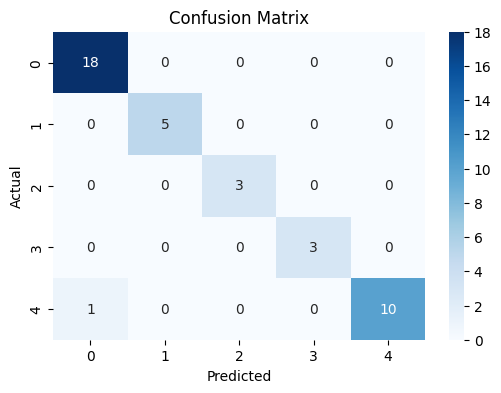

In [ ]:
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred),
            annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

###Interactive Confusion Matrix

In [ ]:
import plotly.figure_factory as ff
import numpy as np

cm = confusion_matrix(y_test, y_pred)
fig = ff.create_annotated_heatmap(
    z=cm, x=list(np.unique(y)), y=list(np.unique(y)),
    colorscale='Blues', showscale=True
)
fig.update_layout(title="Confusion Matrix (Interactive)")
fig.show()

###cross-validation

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_model, X, y, cv=cv)

print("Cross Validation Accuracy:", cv_scores.mean())

Cross Validation Accuracy: 0.99


###Feature Importance & SHAP (Explainability)

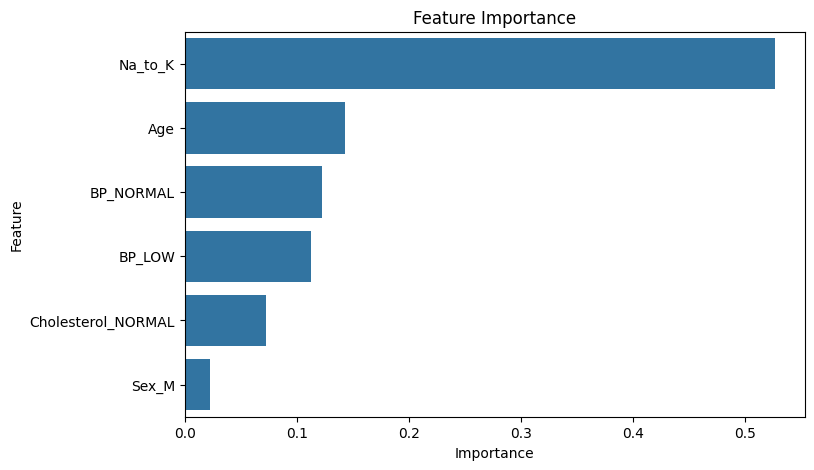

In [ ]:
# Extract trained RF model
rf_model = best_model.named_steps["model"]

# Get feature names
encoded_features = best_model.named_steps["preprocessing"]\
    .transformers_[1][1].get_feature_names_out(categorical_cols)

all_features = numerical_cols + list(encoded_features)

importances = rf_model.feature_importances_

feature_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,5))
sns.barplot(x="Importance", y="Feature", data=feature_df)
plt.title("Feature Importance")
plt.show()

###Save Model

In [ ]:
import plotly.express as px

fig = px.bar(feature_df, x="Importance", y="Feature", orientation='h',
             title="Feature Importance (Interactive)")
fig.show()

In [ ]:
joblib.dump(best_model, "drug_classifier.pkl")

['drug_classifier.pkl']

###Interactive Prediction in Colab

In [ ]:
# Define widgets
age_w = widgets.IntSlider(min=0, max=100, step=1, value=30, description="Age")
sex_w = widgets.Dropdown(options=["M", "F"], description="Sex")
bp_w = widgets.Dropdown(options=["LOW", "NORMAL", "HIGH"], description="BP")
chol_w = widgets.Dropdown(options=["NORMAL", "HIGH"], description="Cholesterol")
na_to_k_w = widgets.FloatSlider(min=4, max=40, step=0.1, value=12, description="Na_to_K")
button = widgets.Button(description="Predict Drug")

display(age_w, sex_w, bp_w, chol_w, na_to_k_w, button)

def predict_drug(b):
    age = age_w.value
    sex = sex_w.value.upper()
    bp = bp_w.value.upper()
    chol = chol_w.value.upper()
    na_to_k = na_to_k_w.value

    input_df = pd.DataFrame([[age, sex, bp, chol, na_to_k]],
                            columns=['Age','Sex','BP','Cholesterol','Na_to_K'])
    prediction = best_model.predict(input_df)
    print(f"Predicted Drug: {prediction[0]}")

button.on_click(predict_drug)

IntSlider(value=30, description='Age')

Dropdown(description='Sex', options=('M', 'F'), value='M')

Dropdown(description='BP', options=('LOW', 'NORMAL', 'HIGH'), value='LOW')

Dropdown(description='Cholesterol', options=('NORMAL', 'HIGH'), value='NORMAL')

FloatSlider(value=12.0, description='Na_to_K', max=40.0, min=4.0)

Button(description='Predict Drug', style=ButtonStyle())

In [ ]:
import plotly.express as px

fig = px.histogram(data, x="Drug", color="Sex", barmode="group",
                   title="Drug Distribution by Sex")
fig.show()

fig2 = px.scatter(data, x="Age", y="Na_to_K", color="Drug", hover_data=['Sex', 'BP', 'Cholesterol'])
fig2.show()

###SHAP Explanation of RandomForest Predictions

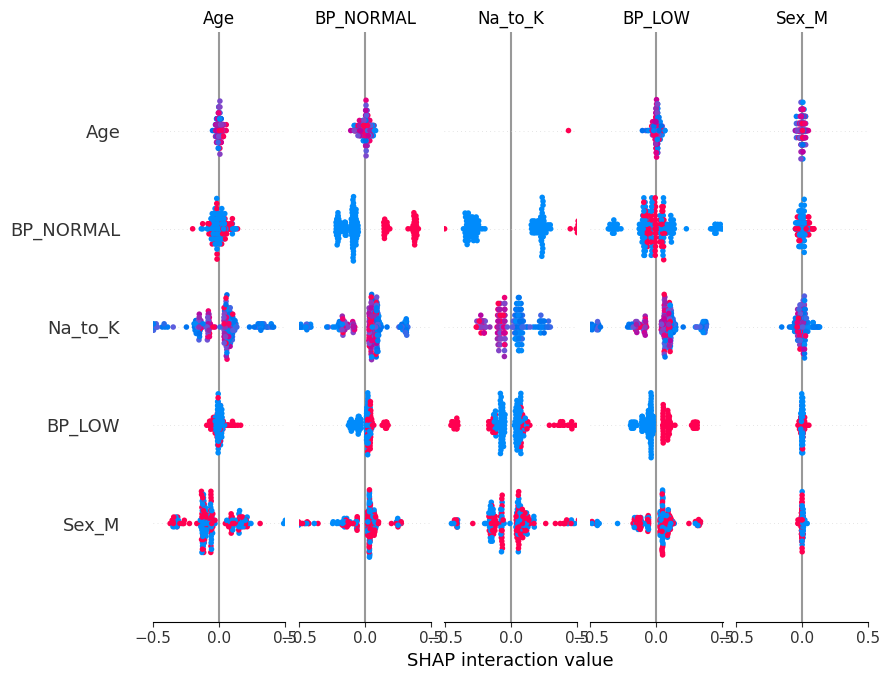

In [ ]:
import shap

# Explain RandomForest predictions
explainer = shap.TreeExplainer(best_model.named_steps["model"])
X_processed = best_model.named_steps["preprocessing"].transform(X)
shap_values = explainer.shap_values(X_processed)

shap.summary_plot(shap_values, X_processed, feature_names=all_features)

###Stacking Classifier Setup

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('svc', SVC(probability=True))
]

stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

###Learning Curve Analysis

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(best_model, X, y, cv=5)

###Interactive Prediction Using input() (Colab)

In [ ]:
import joblib
import pandas as pd

# Load trained model
best_model = joblib.load("drug_classifier.pkl")

# Interactive input for one patient
age = int(input("Enter Age: "))
sex = input("Enter Sex (M/F): ").upper()
bp = input("Enter BP (LOW/NORMAL/HIGH): ").upper()
chol = input("Enter Cholesterol (NORMAL/HIGH): ").upper()
na_to_k = float(input("Enter Na_to_K: "))

# Create dataframe
input_df = pd.DataFrame([[age, sex, bp, chol, na_to_k]], columns=['Age','Sex','BP','Cholesterol','Na_to_K'])

# Predict
prediction = best_model.predict(input_df)
print("Predicted Drug:", prediction[0])

Enter Age: 25
Enter Sex (M/F): F
Enter BP (LOW/NORMAL/HIGH): LOW
Enter Cholesterol (NORMAL/HIGH): HIGH
Enter Na_to_K: 6.8
Predicted Drug: drugC


In [ ]:
from google.colab import files

uploaded = files.upload()  # This will open a file picker

Saving drug_prediction (1).ipynb to drug_prediction (1).ipynb
